<a href="https://colab.research.google.com/github/BhardwajArjit/Research-Paper-Replication/blob/main/CaaM_Replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook replicates the research paper titled "**Causal Attention for Unbiased Visual Recognition**" with PyTorch.

The link to the paper: https://arxiv.org/abs/2108.08782

**Causal Attention Module** (CaaM) generates data partition iteratively and self-annotates the confounders progressively to overcome the over-adjustment problem.

The ultimate goal of CaaM is to improve causal inference by adjusting for confounders more accurately.

##0. Get Setup

In [1]:
try:
  import torch
  import torchvision
  import timm
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
  print(f"timm version: {timm.__version__}")
except:
  print(f"[INFO] Couldn't find timm... installing it.")
  !pip install timm
  import timm
  print(f"timm {timm.__version__} installed successfully...")

[INFO] Couldn't find timm... installing it.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.4 MB/s eta 0:00:00
timm 0.9.10 installed successfully...


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print(f"[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  print("torchinfo installed successfully...")
  from torchinfo import summary

# try:
#     from pytorch_utils import download_data, set_seeds, plot_loss_curves
# except ImportError:
#     # If the import fails, clone the repository
#     !git clone https://github.com/BhardwajArjit/Helper-Functions.git
#     !mv Helper-Functions/pytorch_utils.py .
#     !rm -rf Helper-Functions
#     from pytorch_utils import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
torchinfo installed successfully...


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# GPU provided by Google Colab
!nvidia-smi

Sun Nov  5 17:06:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##1. Get Data

The dataset that the researchers have used is the animal subset of NICO.

The google drive link to the provided dataset: https://drive.google.com/drive/folders/17-jl0fF9BxZupG75BtpOqJaB6dJ2Pv8O?usp=sharing

This notebook is currently using the subset of this dataset provided by the researchers for faster computation and experimentation.

The dataset (ours currently) contains:

1. 75 images for training of 3 different classes: bird, rat and sheep.
2. 30 images for testing purposes.

The link to the current dataset: https://github.com/BhardwajArjit/Research-Paper-Replication/raw/main/nico_subset.zip

The whole point is to speed up how fast we can experiment.

In [5]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data")
image_path = data_path / "nico_subset"

if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "nico_subset.zip", "wb") as f:
  request = requests.get("https://github.com/BhardwajArjit/Research-Paper-Replication/raw/main/nico_subset.zip")
  print("Downloading nico subset data...")
  f.write(request.content)

with zipfile.ZipFile(data_path / "nico_subset.zip", "r") as zip_ref:
  print(f"Uzipping nico subset data...")
  zip_ref.extractall(data_path)

data/nico_subset does not exist, creating one...
Uzipping nico subset data...


##2. Becoming one with the data (data preparation and data exploration)

In [6]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/nico_subset'.
There are 3 directories and 0 images in 'data/nico_subset/train'.
There are 0 directories and 25 images in 'data/nico_subset/train/rat'.
There are 0 directories and 25 images in 'data/nico_subset/train/sheep'.
There are 0 directories and 25 images in 'data/nico_subset/train/bird'.
There are 3 directories and 0 images in 'data/nico_subset/test'.
There are 0 directories and 10 images in 'data/nico_subset/test/rat'.
There are 0 directories and 10 images in 'data/nico_subset/test/sheep'.
There are 0 directories and 10 images in 'data/nico_subset/test/bird'.


In [8]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/nico_subset/train'), PosixPath('data/nico_subset/test'))

## 2.1 Visualizing an image

Random image path: data/nico_subset/test/sheep/0_3_18.jpg
Image class: sheep
Image height: 410
Image width: 615


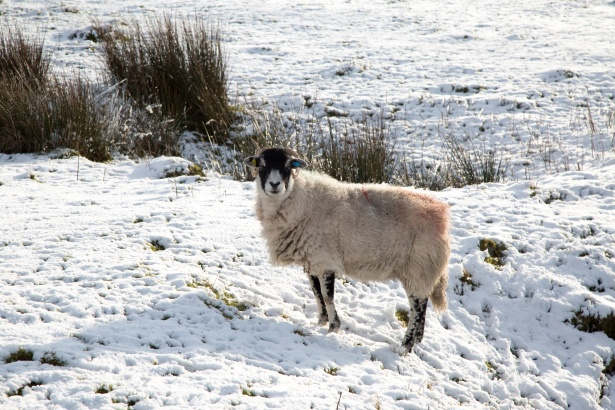

In [9]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

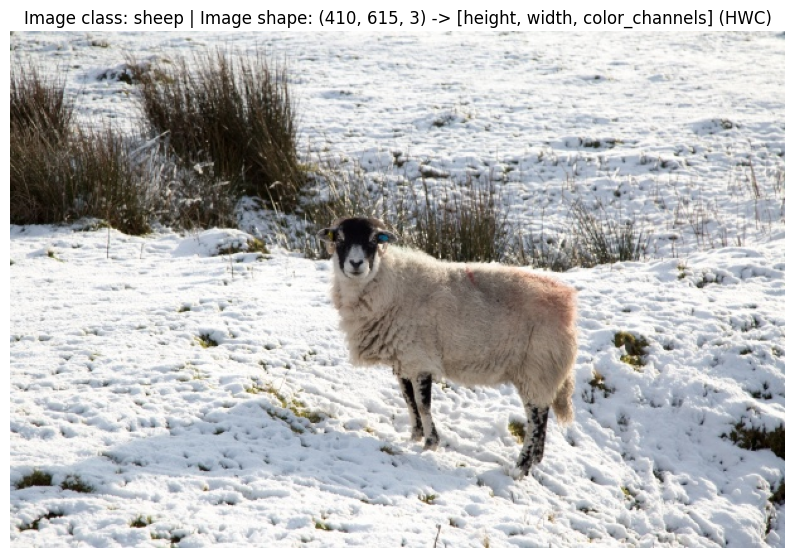

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

In [11]:
img_as_array

array([[[135, 136, 128],
        [140, 141, 133],
        [173, 173, 163],
        ...,
        [229, 233, 236],
        [195, 203, 205],
        [163, 170, 176]],

       [[103, 104,  96],
        [120, 121, 113],
        [160, 160, 150],
        ...,
        [196, 201, 205],
        [151, 160, 165],
        [114, 123, 128]],

       [[ 91,  93,  82],
        [121, 123, 112],
        [193, 193, 185],
        ...,
        [148, 157, 166],
        [125, 138, 146],
        [102, 115, 123]],

       ...,

       [[252, 248, 247],
        [252, 248, 247],
        [245, 241, 240],
        ...,
        [134, 145, 163],
        [143, 154, 172],
        [142, 155, 172]],

       [[235, 234, 232],
        [242, 241, 239],
        [241, 240, 238],
        ...,
        [150, 161, 179],
        [140, 151, 169],
        [143, 154, 174]],

       [[236, 235, 233],
        [240, 239, 237],
        [235, 234, 232],
        ...,
        [150, 161, 179],
        [140, 151, 169],
        [142, 153, 173]]

## 3. Transform data

Before we can use our image data with PyTorch:

1. Turn our target data into tensors.
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`.

In [12]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 3.1 Transforming data with `torchvision.transforms`

In [13]:
data_transform = transforms.Compose([
    #Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    #Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #Turn the image into torch.Tensor
    transforms.ToTensor()
])

In [14]:
data_transform(img).shape

torch.Size([3, 64, 64])

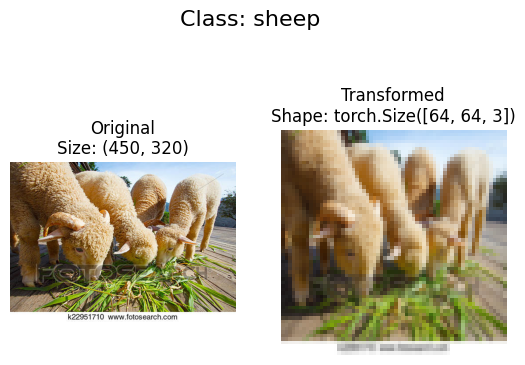

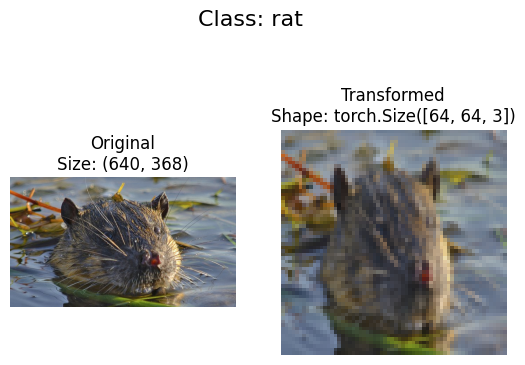

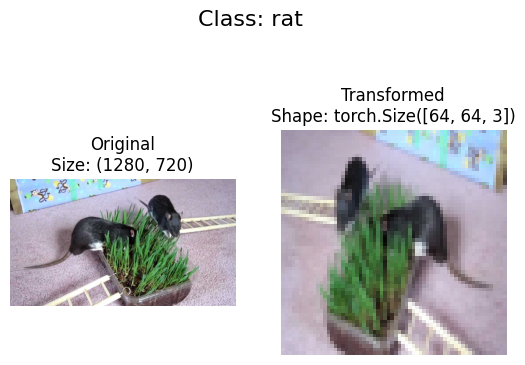

In [15]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 3.2 Loading image data using `ImageFolder`

In [16]:
# Use ImageFolder to create dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/nico_subset/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 29
     Root location: data/nico_subset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
train_dir, test_dir

(PosixPath('data/nico_subset/train'), PosixPath('data/nico_subset/test'))

In [18]:
# Get class names as list
class_names = train_data.classes
class_names

['bird', 'rat', 'sheep']

In [19]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'bird': 0, 'rat': 1, 'sheep': 2}

In [20]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(75, 29)

In [21]:
train_data.samples[0]

('data/nico_subset/train/bird/1_11_177.jpg', 0)

In [22]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1412, 0.1412, 0.1451,  ..., 0.4706, 0.4353, 0.3608],
         [0.1490, 0.1529, 0.1608,  ..., 0.2039, 0.1725, 0.1529],
         [0.1451, 0.1529, 0.1608,  ..., 0.1255, 0.1020, 0.0941],
         ...,
         [0.2824, 0.3765, 0.3686,  ..., 0.4667, 0.4235, 0.4510],
         [0.2314, 0.2863, 0.2941,  ..., 0.4431, 0.4039, 0.4078],
         [0.3059, 0.3059, 0.3176,  ..., 0.4588, 0.4353, 0.4235]],

        [[0.1294, 0.1294, 0.1333,  ..., 0.4353, 0.4039, 0.3373],
         [0.1373, 0.1412, 0.1490,  ..., 0.1961, 0.1725, 0.1529],
         [0.1294, 0.1412, 0.1529,  ..., 0.1373, 0.1176, 0.1098],
         ...,
         [0.2941, 0.3765, 0.3686,  ..., 0.4588, 0.4314, 0.4510],
         [0.2471, 0.2980, 0.2941,  ..., 0.4314, 0.4000, 0.4078],
         [0.3059, 0.2902, 0.3098,  ..., 0.4510, 0.4275, 0.4118]],

        [[0.1020, 0.0941, 0.0902,  ..., 0.4471, 0.4157, 0.3451],
         [0.1098, 0.1098, 0.1137,  ..., 0.2039, 0.1804, 0.1647],
         [0.0980, 0.1020, 0.1098,  ..., 0.1

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'bird')

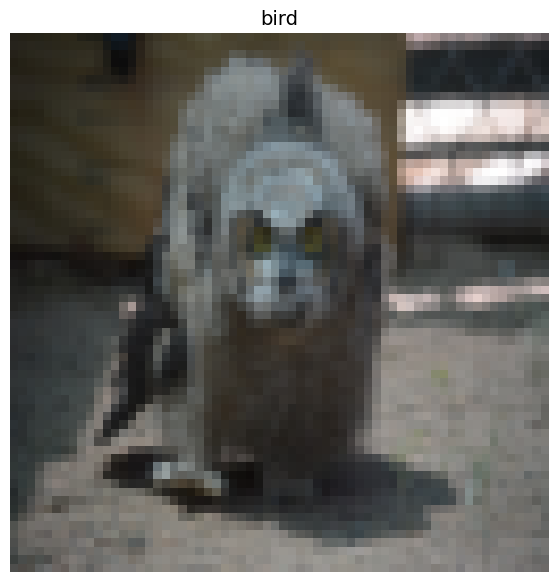

In [23]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

## 3.3 Turn loaded images into `DataLoader`

In [24]:
import os
os.cpu_count()

2

In [25]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d5e1347fc70>,
 <torch.utils.data.dataloader.DataLoader at 0x7d5e077bcbe0>)

In [26]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 3.3 Create a function to display random images

In [27]:
from typing import Tuple, Dict, List
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

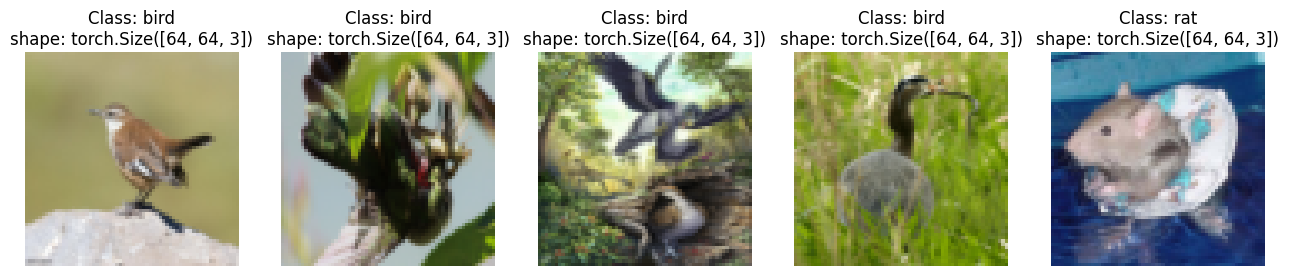

In [28]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)